I have used the following methods.

* I have implemented DeepLabv3+ stemmed from this Keras example[1,2],
* I inverted the original masks <b><span style="color:#e74c3c;"></span></b> in the image preprocessing stage,
* <b>Dice coefficient</b> and <b>Jaccard index</b> implementation[3],
* I used <b><span style="color:#e74c3c;"> DeepLabv3+ implementation</span></b> with ResNet50 backbone,
* Used tf.data for input pipeline,
* <b>A Custom layer</b> for convolution operation,
* <b>A Custom layer</b> for Dilated Spatial Pyramid Pooling operation,
* I don't use validation dataset
    
 
    
## Test Set Predictions
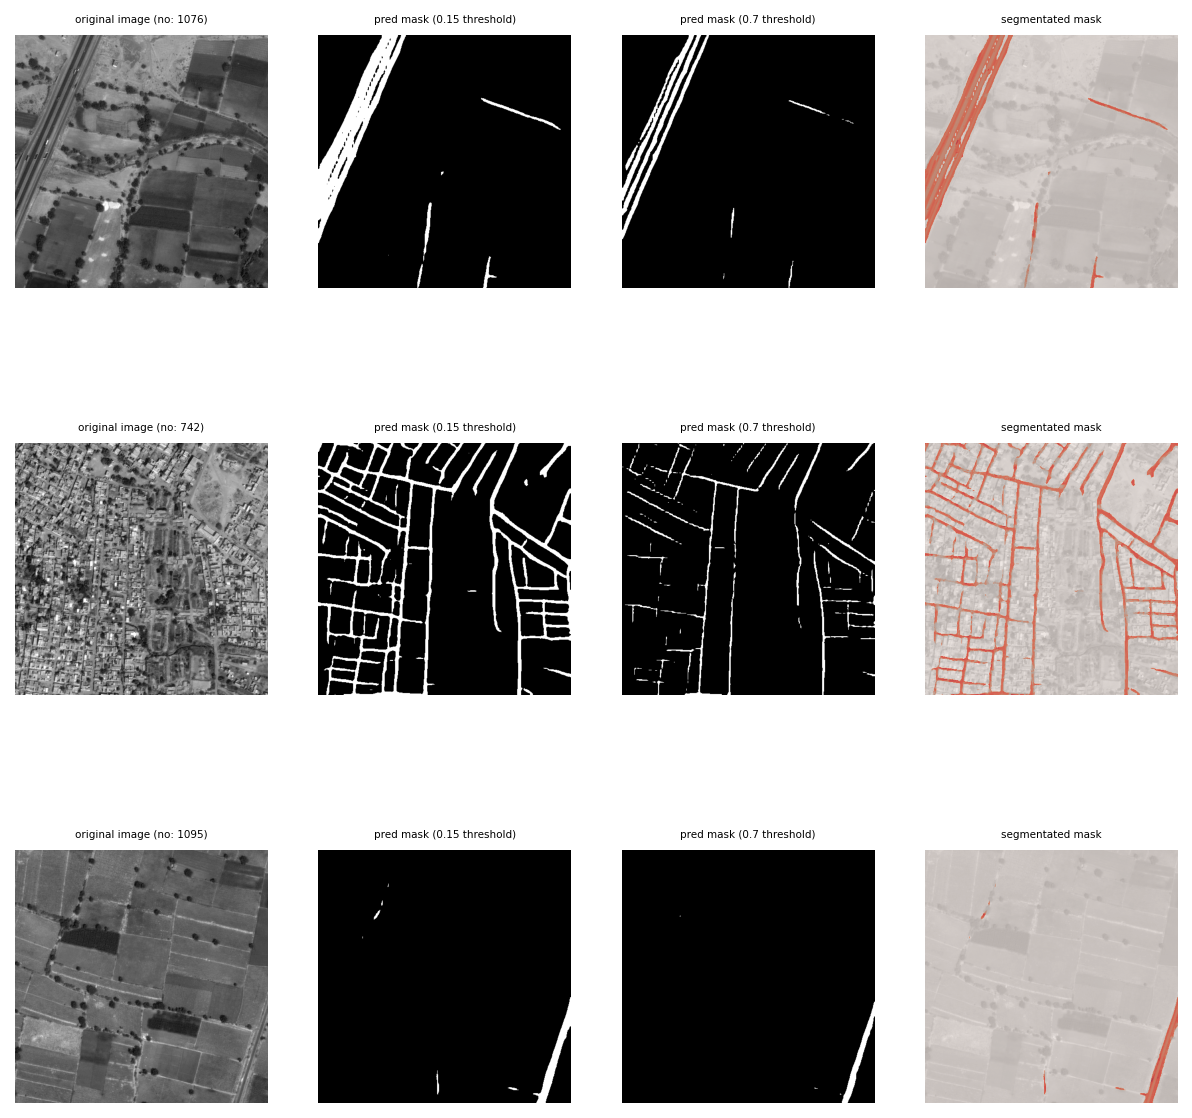


    
## My Another Segmentation Projects

* [Power Forecasting w/Online Learning (River)](https://www.kaggle.com/code/banddaniel/power-forecasting-w-online-learning-river)
* [Lung Segmentation UNet w/SeparableConv (Dice:0.93)](https://www.kaggle.com/code/banddaniel/lung-segmentation-unet-w-separableconv-dice-0-93)
* [Smoking Detection w/Online Learning (River)](https://www.kaggle.com/code/banddaniel/smoking-detection-w-online-learning-river)


## References
1. https://keras.io/examples/vision/deeplabv3_plus/#building-the-deeplabv3-model
2. Chen, L.-C., Zhu, Y., Papandreou, G., Schroff, F., & Adam, H. (2018). Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation (Version 3). arXiv. https://doi.org/10.48550/ARXIV.1802.02611
3. https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient
4. https://en.wikipedia.org/wiki/Leakage_(machine_learning)

In [1]:
# Importing dependencies

import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import random 
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Layer, Input, Conv2D, UpSampling2D, Dropout, Concatenate, BatchNormalization, SeparableConv2D
from tensorflow.keras.layers import Activation, MaxPooling2D, AveragePooling2D, Dense, concatenate, GlobalAveragePooling2D 

SEED = 4
IMG_SIZE = 512, 512
BATCH_SIZE = 8
AUTO = tf.data.AUTOTUNE

# <span style="color:#e74c3c;"> Creating </span> Datasets


In [2]:
data = pd.read_csv('/kaggle/input/road-detection-dataset-with-masks/deepglobe-road-extraction-dataset/metadata.csv')

train_data = data[data['split'] == 'train']
test_data = data[data['split'] == 'test']

train_data['full_img_path'] = '/kaggle/input/road-detection-dataset-with-masks/deepglobe-road-extraction-dataset/' + train_data['sat_image_path']
train_data['full_mask_path'] = '/kaggle/input/road-detection-dataset-with-masks/deepglobe-road-extraction-dataset/' + train_data['mask_path']


test_data['full_img_path'] = '/kaggle/input/road-detection-dataset-with-masks/deepglobe-road-extraction-dataset/' + test_data['sat_image_path']

# empty mask file
test_data['full_mask_path'] = '/kaggle/input/road-detection-dataset-with-masks/deepglobe-road-extraction-dataset/train/00001_mask.png'

train_data.head()

,image_id,split,sat_image_path,mask_path,full_img_path,full_mask_path
0,100034,train,train/100034_sat.jpg,train/100034_mask.png,/kaggle/input/road-detection-dataset-with-mask...,/kaggle/input/road-detection-dataset-with-mask...
1,100081,train,train/100081_sat.jpg,train/100081_mask.png,/kaggle/input/road-detection-dataset-with-mask...,/kaggle/input/road-detection-dataset-with-mask...
2,100129,train,train/100129_sat.jpg,train/100129_mask.png,/kaggle/input/road-detection-dataset-with-mask...,/kaggle/input/road-detection-dataset-with-mask...
3,100703,train,train/100703_sat.jpg,train/100703_mask.png,/kaggle/input/road-detection-dataset-with-mask...,/kaggle/input/road-detection-dataset-with-mask...
4,100712,train,train/100712_sat.jpg,train/100712_mask.png,/kaggle/input/road-detection-dataset-with-mask...,/kaggle/input/road-detection-dataset-with-mask...


# <span style="color:#e74c3c;"> Creating </span> tf.data Pipeline

In [3]:
# Reading and resizing images and masks

def img_preprocessing(img, mask):
    img = tf.io.read_file(img)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    
    mask = tf.io.read_file(mask)
    mask = tf.io.decode_png(mask, channels = 1)
    mask = tf.image.resize(mask, size = (IMG_SIZE))
    mask = tf.cast(mask, tf.float32) / 255.0
    
    return img, mask

In [4]:
# Creating dataset loaders and tf.datasets

train_loader = tf.data.Dataset.from_tensor_slices((train_data['full_img_path'], train_data['full_mask_path']))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .shuffle(BATCH_SIZE*10)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))


test_loader = tf.data.Dataset.from_tensor_slices((test_data['full_img_path'], test_data['full_mask_path']))
test_dataset = (test_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))

# <span style="color:#e74c3c;"> Creating </span> Custom Layers

In [5]:
# Convolutional block class

class ConvBlock(Layer):
    def __init__(self, filters, kernel_size, dilation_rate, batch = False, padding = 'same', activation = 'relu', use_bias = False, **kwargs):
        super(ConvBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        self.batch = batch
        self.padding = padding
        self.activation = activation
        self.use_bias = use_bias
        
        self.conv = Conv2D(filters, kernel_size = kernel_size, dilation_rate = dilation_rate, padding = padding, use_bias = use_bias, kernel_initializer = 'he_normal')
        self.b_norm = BatchNormalization()
        self.act = Activation(activation)
        
    
    def call(self, inputs):
        X = self.conv(inputs)
        if self.batch:
            X = self.b_norm(X)
            X = self.act(X)
            return X
        else:
            X = self.act(X)
            return X

    
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters" : self.filters,
            "kernel_size" : self.kernel_size,
            "dilation_rate" : self.dilation_rate,
            "activation" : self.act,
            "batch" : self.batch }

In [6]:
# DilatedSpatialPyramidPooling class for DeepLabv3+ model

class DilatedSpatialPyramidPooling(Layer):
    def __init__(self, input_layer, kernel_1, kernel_2, kernel_3, kernel_4, dil1, dil2, dil3, dil4, **kwargs):
        super(DilatedSpatialPyramidPooling, self).__init__(**kwargs)
        self.input_layer = input_layer
        self.kernel_1 = kernel_1
        self.kernel_2 = kernel_2
        self.kernel_3 = kernel_3
        self.kernel_4 = kernel_4
        self.dil1 = dil1
        self.dil2 = dil2
        self.dil3 = dil3
        self.dil4 = dil4
 
        self.pool = AveragePooling2D(pool_size = (input_layer.shape[-3], input_layer.shape[-2]))
        self.convblock = ConvBlock(filters = 256, kernel_size=1, dilation_rate=1, batch = True, use_bias=True)
        self.outpool = UpSampling2D(size=(32,32), interpolation="bilinear")
        self.convout1 = ConvBlock(filters = 256, kernel_size = kernel_1, dilation_rate = dil1, batch = True)
        self.convout2 = ConvBlock(filters = 256, kernel_size = kernel_2, dilation_rate = dil2, batch = True)
        self.convout3 = ConvBlock(filters = 256, kernel_size = kernel_3, dilation_rate = dil3, batch = True)
        self.convout4 = ConvBlock(filters = 256, kernel_size = kernel_4, dilation_rate = dil4, batch = True)
        self.outconv = ConvBlock(filters = 256, kernel_size = 1, dilation_rate=1, batch = True)

    
    def call(self, inputs):
        X = self.pool(inputs)
        X = self.convblock(X)
        X_p = self.outpool(X)
        X_1 = self.convout1(inputs)
        X_2 = self.convout2(inputs)
        X_3 = self.convout3(inputs)
        X_4 = self.convout4(inputs)
        
        C = concatenate([X_p, X_1, X_2, X_3, X_4], axis = -1)
        X = self.outconv(C)
        return X

    
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "input_layer": self.input_layer,
            "kernel_1" : self.kernel_1,
            "kernel_2" : self.kernel_2,
            "kernel_3" : self.kernel_3,
            "kernel_4" : self.kernel_4,
            "dil1" : self.dil1,
            "dil2" : self.dil2,
            "dil3" : self.dil3,
            "dil4" : self.dil4}

In [7]:
# Creating Dice and Jaccard metrics

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection+1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def jaccard(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    jaccard = intersection  / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1e-6 )
    return jaccard

# <span style="color:#e74c3c;"> DeepLabv3+</span> Model


In [8]:
inp = Input(shape = (*IMG_SIZE ,3))
pretrained = ResNet50(weights="imagenet", include_top=False, input_tensor=inp)
X = pretrained.get_layer("conv4_block6_2_relu").output
X = DilatedSpatialPyramidPooling(X, kernel_1 = 1, kernel_2 = 3, kernel_3 = 3, kernel_4 = 3,
                                 dil1 = 1, dil2 = 6, dil3 = 12, dil4 = 18)(X)

X_1 = UpSampling2D(size = (IMG_SIZE[0] // 4 // X.shape[1], IMG_SIZE[0] // 4 // X.shape[2]), interpolation="bilinear")(X)

X_2 = pretrained.get_layer("conv2_block3_2_relu").output
X_2 = ConvBlock(filters=48, kernel_size=1, dilation_rate =1)(X_2)

X = Concatenate(axis=-1)([X_1, X_2])
X = ConvBlock(filters = 256, kernel_size = 3, dilation_rate = 1)(X)
X = ConvBlock(filters = 256, kernel_size = 3, dilation_rate = 1)(X)
X = UpSampling2D(size = (IMG_SIZE[0] // X.shape[1], IMG_SIZE[0] // X.shape[2]), interpolation="bilinear")(X)

out = Conv2D(1, 1 ,activation ='sigmoid', padding = 'same')(X)

model = Model(inputs = inp, outputs = out)
model.compile(optimizer = tf.keras.optimizers.AdamW(learning_rate = 0.0001, weight_decay = 0.0001), loss = 'binary_crossentropy' , metrics = [dice_coef_loss, dice_coef, jaccard]) 

94765736/94765736 [==============================] - 3s 0us/step


# <span style="color:#e74c3c;"> Training </span> 

In [9]:
hist = model.fit(train_dataset, batch_size = BATCH_SIZE, epochs = 30)

Epoch 1/30
779/779 [==============================] - 348s 390ms/step - loss: 0.0898 - dice_coef_loss: 0.5883 - dice_coef: 0.4117 - jaccard: 0.2659
Epoch 2/30
779/779 [==============================] - 301s 385ms/step - loss: 0.0642 - dice_coef_loss: 0.4437 - dice_coef: 0.5563 - jaccard: 0.3868
Epoch 3/30
779/779 [==============================] - 303s 387ms/step - loss: 0.0562 - dice_coef_loss: 0.3944 - dice_coef: 0.6056 - jaccard: 0.4357
Epoch 4/30
779/779 [==============================] - 303s 388ms/step - loss: 0.0504 - dice_coef_loss: 0.3569 - dice_coef: 0.6431 - jaccard: 0.4754
Epoch 5/30
779/779 [==============================] - 301s 385ms/step - loss: 0.0456 - dice_coef_loss: 0.3264 - dice_coef: 0.6736 - jaccard: 0.5093
Epoch 6/30
779/779 [==============================] - 301s 386ms/step - loss: 0.0420 - dice_coef_loss: 0.3025 - dice_coef: 0.6975 - jaccard: 0.5370
Epoch 7/30
779/779 [==============================] - 301s 385ms/step - loss: 0.0392 - dice_coef_loss: 0.2836 - 

# <span style="color:#e74c3c;"> Training </span> Results, Evaluation

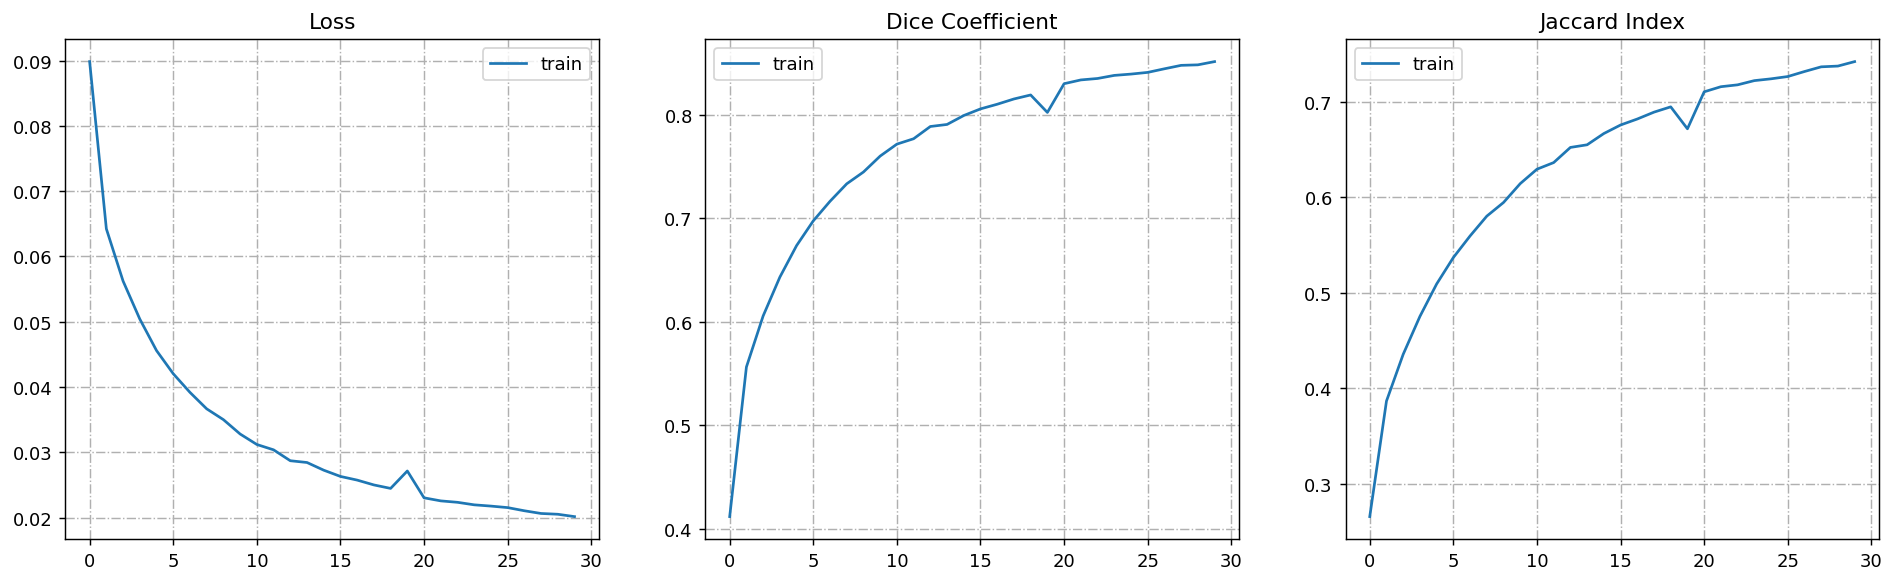

In [10]:
fig, axs = plt.subplots(1,3, figsize = (18,5), dpi = 130)

axs[0].grid(linestyle="dashdot")
axs[0].set_title("Loss")
axs[0].plot(hist.history['loss'])
axs[0].legend(["train"])

axs[1].grid(linestyle="dashdot")
axs[1].set_title("Dice Coefficient")
axs[1].plot(hist.history['dice_coef'])
axs[1].legend(["train"])

axs[2].grid(linestyle="dashdot")
axs[2].set_title("Jaccard Index")
axs[2].plot(hist.history['jaccard'])
axs[2].legend(["train"])

# <span style="color:#e74c3c;"> Test </span> Predictions

In [11]:
test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)
pred = model.predict(test_take1)

y_test_take = []
for x in range(len(test_take1_)):
    y_test_take.extend(test_take1_[x][1].numpy())
    
pred_ = np.squeeze(pred)

threshold_1  = 0.15 #threshold for prediction
bitmap_pred_1 = (pred_ > threshold_1).astype(np.uint8)

threshold_2  = 0.7 #threshold for prediction
bitmap_pred_2 = (pred_ > threshold_2).astype(np.uint8)

138/138 [==============================] - 17s 120ms/step


In [12]:
# A function that creating one random image in the test set and prediction it

def random_test_sample_with_prediction(SEED):
    idxs = np.random.default_rng(seed=SEED).permutation(len(y_test_take))[:3]

    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs


    fig, axs = plt.subplots(3,4, figsize = (10, 10) ,dpi = 150)
    
    for i in range(3):
        image = test_take1_[batch_idx[i]][0][image_idx[i]]
        pred_mask_1 = bitmap_pred_1[idx[i]]
        pred_mask_2 = bitmap_pred_2[idx[i]]

        segmented = np.squeeze(image[:,::,0]) * pred_mask_1
        

        axs[i][0].imshow(image , cmap = 'gray')
        axs[i][0].axis('off')
        axs[i][0].set_title('original image (no: ' + str(idxs[i]) + ")", fontsize = 5)

        axs[i][1].imshow(pred_mask_1 , cmap = 'gray')
        axs[i][1].axis('off')
        axs[i][1].set_title('pred mask (0.15 threshold)', fontsize = 5)
    
        axs[i][2].imshow(pred_mask_2 , cmap = 'gray')
        axs[i][2].axis('off')
        axs[i][2].set_title('pred mask (0.7 threshold)', fontsize = 5)
        
        axs[i][3].imshow(image , cmap ='gray')
        axs[i][3].imshow(segmented , alpha=0.2,  cmap ='gray')
        axs[i][3].imshow(segmented , alpha=0.7,  cmap ='Reds')
        axs[i][3].axis('off')
        axs[i][3].set_title('segmentated mask (0.15 threshold)', fontsize = 5)

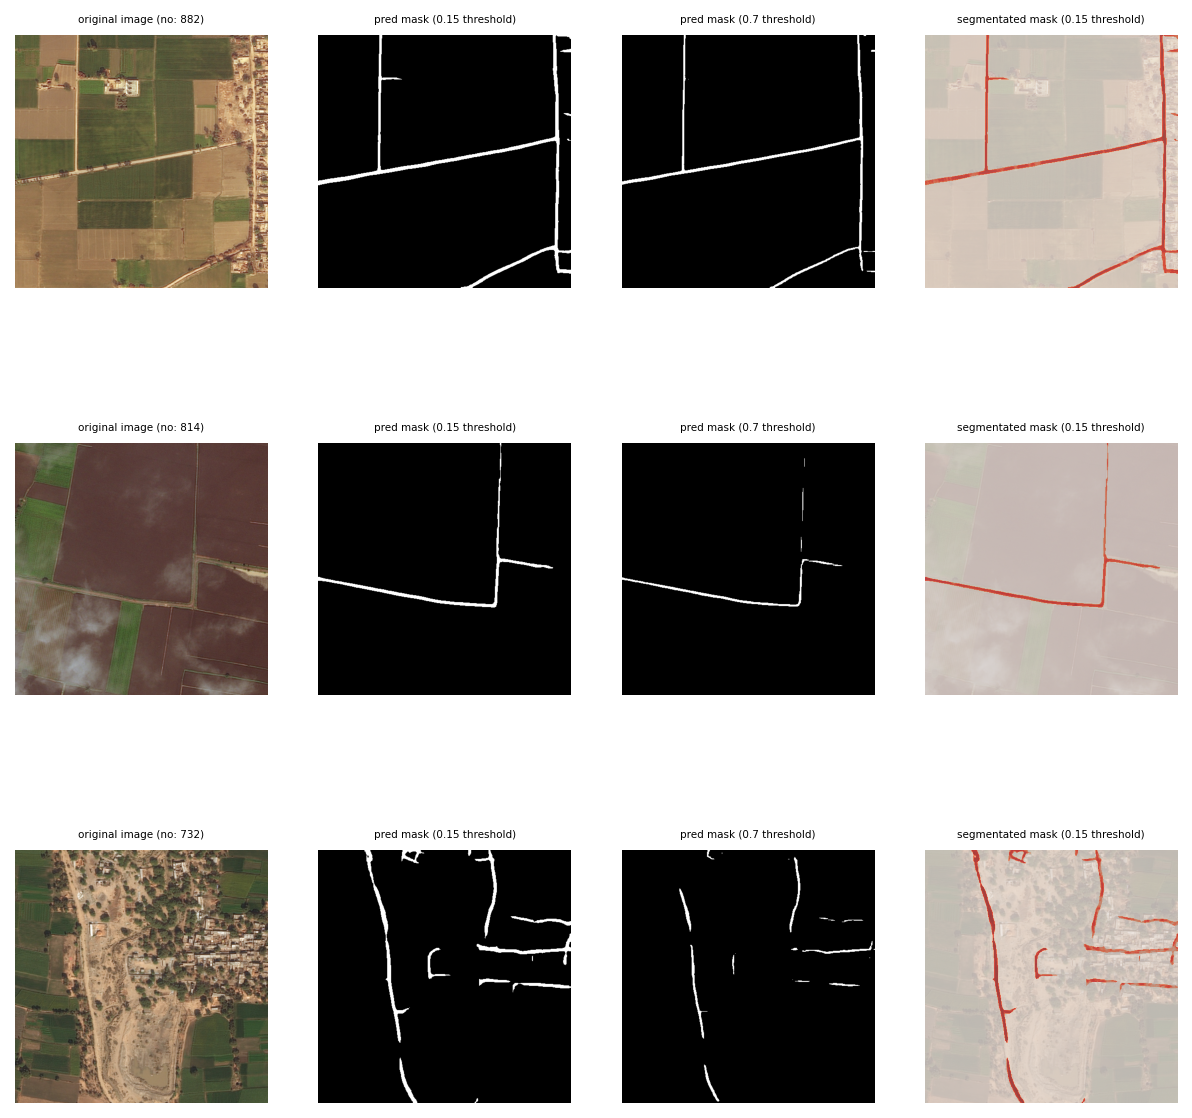

In [13]:
random_test_sample_with_prediction(39)